In [12]:
import pandas as pd
import numpy as np

data = pd.read_json('user_data/data/binance/BTC_USDT-5m.json')
data.columns=['timestamp','opening','high','low','close','volumn']
data=data.drop(['high','low'], axis=1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  834 non-null    int64  
 1   opening    834 non-null    float64
 2   close      834 non-null    float64
 3   volumn     834 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 26.2 KB


In [18]:
data['timestamp']=pd.to_datetime(data['timestamp'],unit='ms')

In [24]:
new_row = pd.DataFrame(data.iloc[0]).T
data=pd.concat([new_row, data]).reset_index(drop = True) 
data.loc[0,'cur_val']=data.loc[0,'opening']
data.loc[0,'cur_color']=None
data.loc[0,'num_blocks']=None
data.loc[0,'cur_volumn']=0

for i, row in data.iterrows():
    if 0<i<len(data):
        cur_val = data.loc[i-1,'cur_val']
        cur_color = data.loc[i-1,'cur_color']
        color = 'red' if (data.loc[i,'close']<cur_val) else 'green' 
             
        if color==cur_color or pd.isna(cur_color):
            num_blocks = abs(int((data.loc[i,'close']-cur_val)/16))
            if num_blocks>0:
                cur_val = data.loc[i,'close']
                cur_color=color
        elif color!=cur_color:
            num_blocks = abs(int((data.loc[i,'close']-cur_val)/16))-1
            if num_blocks>0:
                cur_val = data.loc[i,'close']
                cur_color = color 
        data.loc[i,'cur_val']=cur_val
        data.loc[i,'cur_color']=cur_color
        data.loc[i,'num_blocks']=num_blocks

        
        if  i==1 or data.loc[i-1,'num_blocks']>0:
            data.loc[i,'cur_volumn']=data.loc[i,'volumn']
        else:
            data.loc[i,'cur_volumn']=data.loc[i-1,'cur_volumn']+data.loc[i,'volumn']
            
df=data[data['num_blocks']>0]
        

In [25]:
df

timestamp  opening    close   volumn  cur_val cur_color  \
1   2020-04-15 00:00:00  6868.57  6830.93  755.499  6830.93       red   
25  2020-04-15 01:40:00  6857.96  6863.23  121.061  6863.23     green   
32  2020-04-15 02:15:00  6871.56  6892.11  109.224  6892.11     green   
53  2020-04-15 04:00:00  6906.56  6924.63  411.412  6924.63     green   
64  2020-04-15 04:55:00  6903.33  6891.29  140.709  6891.29       red   
..                  ...      ...      ...      ...      ...       ...   
743 2020-04-17 13:30:00  7041.61  7019.57  2136.83  7019.57       red   
748 2020-04-17 13:55:00  7033.26   7059.4  369.868   7059.4     green   
758 2020-04-17 14:45:00  7034.99  7017.19  234.503  7017.19       red   
761 2020-04-17 15:00:00  7024.37  7050.82  416.927  7050.82     green   
819 2020-04-17 19:50:00     7060  7080.92   607.25  7080.92     green   

    num_blocks cur_volumn  
1            2    755.499  
25           1    5599.96  
32           1    873.411  
53           2    2972.04  
64           1    1344.32  
..         ...        ...  
743          1    2136.83  
748          1    1748.88  
758          1    2011.68  
761          1    762.644  
819          1    7665.33  

[82 rows x 8 columns]

In [26]:
df_new=df.copy()
df_new=df_new.reset_index()
df_new['num_blocks'] = df_new['num_blocks'].values.astype(int)

i=0
while i<len(df_new):
    if df_new.loc[i,'num_blocks']>1:
        volumn = df_new.loc[i,'cur_volumn']/df_new.loc[i,'num_blocks']
        df_new.loc[i,'volumn']=volumn
        
        if i==0:
            size = (df_new.loc[i,'cur_val']-df_new.loc[i,'opening'])/df_new.loc[i,'num_blocks']
            df_new.loc[i,'size']=size
            df_new.loc[i,'close']=df_new.loc[i,'opening']+size        
        elif df_new.loc[i,'cur_color']==df_new.loc[i-1,'cur_color']:
            size = (df_new.loc[i,'cur_val']-df_new.loc[i-1,'cur_val'])/df_new.loc[i,'num_blocks']
            df_new.loc[i,'size']=size
            df_new.loc[i,'close']=df_new.loc[i-1,'close']+size
        else:
            size = (df_new.loc[i,'cur_val']-df_new.loc[i-1,'cur_val'])/(df_new.loc[i,'num_blocks']+1)
            df_new.loc[i,'size']=size
            df_new.loc[i,'close']=df_new.loc[i-1,'close']+size*2
            
                                     
        for n in range(df_new.loc[i,'num_blocks']-1):
            line = pd.DataFrame(df_new.iloc[i+n,:]).T
            line.loc[:,'close'] += size
            df_new = pd.concat([df_new.iloc[:i+n+1], line, df_new.iloc[i+n+1:]]).reset_index(drop=True)
       

    i+=df_new.loc[i,'num_blocks']


In [27]:
df_new.loc[0,'size']=df_new.loc[0,'close']-df_new.loc[0,'opening']
for i in range(1,len(df_new)):
    if pd.isna(df_new.loc[i,'size']):
        if df_new.loc[i,'cur_color']!=df_new.loc[i-1,'cur_color']:
            df_new.loc[i,'size']=(df_new.loc[i,'cur_val']-df_new.loc[i-1,'cur_val'])/2
        else:
            df_new.loc[i,'size']=(df_new.loc[i,'cur_val']-df_new.loc[i-1,'cur_val'])
            

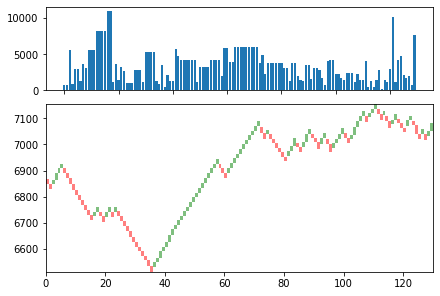

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(3, 3)
ax1 = fig3.add_subplot(gs[0, :])
ax2 = fig3.add_subplot(gs[1:3, :])
plt.setp(ax1.get_xticklabels(), visible=False)

def plot_renko(data):
    ax2.axis([0,len(data),min_val, max_val])

    for i, row in data.iterrows():
        facecolor=data.loc[i,'cur_color']
        if facecolor=='red':
            renko = patches.Rectangle((i, df_new.loc[i,'close']), 1, abs(df_new.loc[i,'size']), facecolor=facecolor, alpha=0.5)
        else:
            renko = patches.Rectangle((i, df_new.loc[i,'close']-abs(df_new.loc[i,'size'])), 1, abs(df_new.loc[i,'size']), facecolor=facecolor, alpha=0.5)
        ax2.add_patch(renko)

    
opening=df_new.loc[0, 'opening']
max_val = max(df_new['cur_val'])
min_val = min(df_new['cur_val'])

ax2=plot_renko(df_new)

ax1.bar(df_new.index,df_new['cur_volumn'])
plt.show()


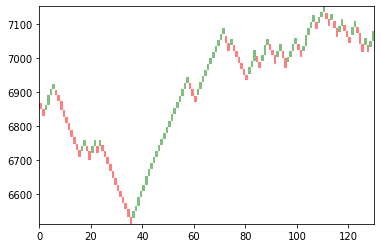

In [34]:
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

def plot_renko(data):
    fig = plt.figure()
    fig.clf()
    axes = fig.gca()
    axes.axis([0,len(data),min_val, max_val])

    for i, row in data.iterrows():
        facecolor=data.loc[i,'cur_color']
        if facecolor=='red':
            renko = Rectangle((i, df_new.loc[i,'close']), 1, abs(df_new.loc[i,'size']), facecolor=facecolor, alpha=0.5)
        else:
            renko = Rectangle((i, df_new.loc[i,'close']-abs(df_new.loc[i,'size'])), 1, abs(df_new.loc[i,'size']), facecolor=facecolor, alpha=0.5)
        axes.add_patch(renko)

    plt.show()


opening=df_new.loc[0, 'opening']
max_val = max(df_new['cur_val'])
min_val = min(df_new['cur_val'])

plot_renko(df_new)